# A/B Testing Course

## Lesson 4. Desing Testing

### Homework

#### Import Libraries

In [37]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [98]:
from scipy.interpolate import interp1d

In [11]:
from scipy.stats import norm, ttest_ind

In [28]:
import random

#### Import Data

In [3]:
URL_BASE = ''

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

In [4]:
df_sales = read_database('2022-04-01T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])

#### Data Description

df_sales - information about purchases, one row represents one order:
- sale_id - purchase identifier;
- date - date of purchase;
- count_pizza - number of pizzas in the order;
- count_drink - number of drinks in the order;
- price - order price;
- user_id - user identifier.   

#### Checking Data

In [5]:
df_sales.head()

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a
3,1000004,2022-02-04 10:03:06,1,1,750,3e8ed5
4,1000005,2022-02-04 10:03:23,1,1,870,cbc468


In [6]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203847 entries, 0 to 203846
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   sale_id      203847 non-null  int64         
 1   date         203847 non-null  datetime64[ns]
 2   count_pizza  203847 non-null  int64         
 3   count_drink  203847 non-null  int64         
 4   price        203847 non-null  int64         
 5   user_id      203847 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 9.3+ MB


#### Task 1. 

Suppose all users who made purchases before March 28th are included in our A/B test.

The target metric is the average revenue per customer during the experiment. We will calculate the target metric for the week from March 21st to March 28th. The significance level is 0.05. The criterion is Student's t-test. The group size is 1000. The expected effect is an increase in average revenue by 10%.

We need to estimate the probabilities of type II errors for three ways of adding the effect:
1. Adding a constant to all values;
1. Multiplying all values by a constant;
1. Adding a constant to 2.5% of values.

Enter the numbers of the methods of adding the effect in order of increasing estimation of the probability of type II error. For example, if the estimation of the probability of error is the lowest when adding a constant to all values, and the highest when adding a constant to 2.5% of values, the answer would be: 123.

In [109]:
# filtering data by date
sales_filt = df_sales[(df_sales['date'] >= '2022-03-21') & \
                      (df_sales['date'] < '2022-03-28')]

In [108]:
# function to plot p-value graphs
def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.axvline(x=0.05, color='grey')
    
    # Define the x value you want to get the y value for
    x = 0.05
    line = ax2.get_lines()[0]
    f = interp1d(line.get_xdata(), line.get_ydata())
    y = f(x)
    print(f"The Beta value for alpha={x} is {y:.2f}")
    
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()

Adding a constant to all values.

The Beta value for alpha=0.05 is 0.94


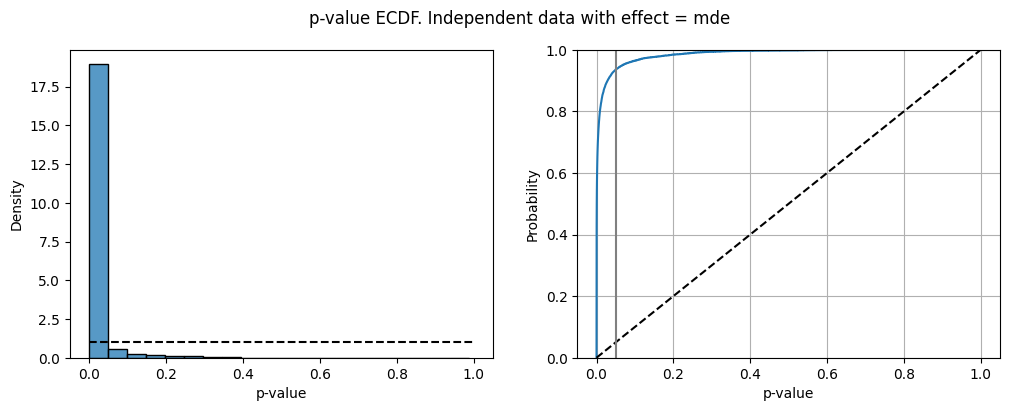

In [105]:
mean = sales_by_user['price'].mean()
std = sales_by_user['price'].std()
sample_size = 1000
alpha = 0.05
#beta = 0.2
effect = 0.1


p_values = []
grouped_sales = sales_filt.groupby('user_id', as_index=False).agg({'price': 'sum'}).reset_index()
users = sales_filt['user_id'].unique().tolist()
for _ in range(10000):
    np.random.shuffle(users)
    group_a = random.sample(users, sample_size)
    group_b = random.sample(users, sample_size)
    sales_a = grouped_sales[grouped_sales['user_id'].isin(group_a)]['price']
    sales_b = grouped_sales[grouped_sales['user_id'].isin(group_b)]['price']
    sales_b = sales_b + mean * effect
    _, p_val = ttest_ind(sales_a, sales_b)
    p_values.append(p_val)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Independent data with effect = mde')

Multiplying all values by a constant.

The Beta value for alpha=0.05 is 0.91


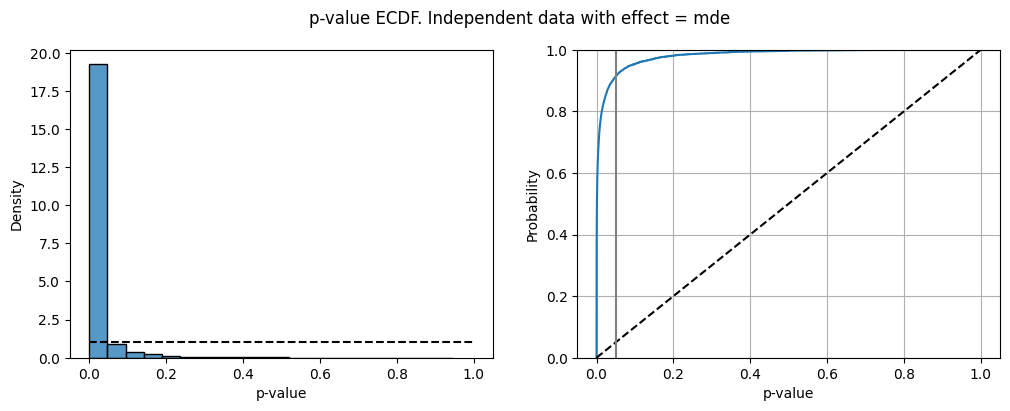

In [106]:
mean = sales_by_user['price'].mean()
std = sales_by_user['price'].std()
sample_size = 1000
alpha = 0.05
#beta = 0.2
effect = 0.1


p_values = []
grouped_sales = sales_filt.groupby('user_id', as_index=False).agg({'price': 'sum'}).reset_index()
users = sales_filt['user_id'].unique().tolist()
for _ in range(10000):
    np.random.shuffle(users)
    group_a = random.sample(users, sample_size)
    group_b = random.sample(users, sample_size)
    sales_a = grouped_sales[grouped_sales['user_id'].isin(group_a)]['price']
    sales_b = grouped_sales[grouped_sales['user_id'].isin(group_b)]['price']
    sales_b = sales_b * (1 + effect)
    _, p_val = ttest_ind(sales_a, sales_b)
    p_values.append(p_val)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Independent data with effect = mde')

Adding a constant to 2.5% of data.

The Beta value for alpha=0.05 is 0.86


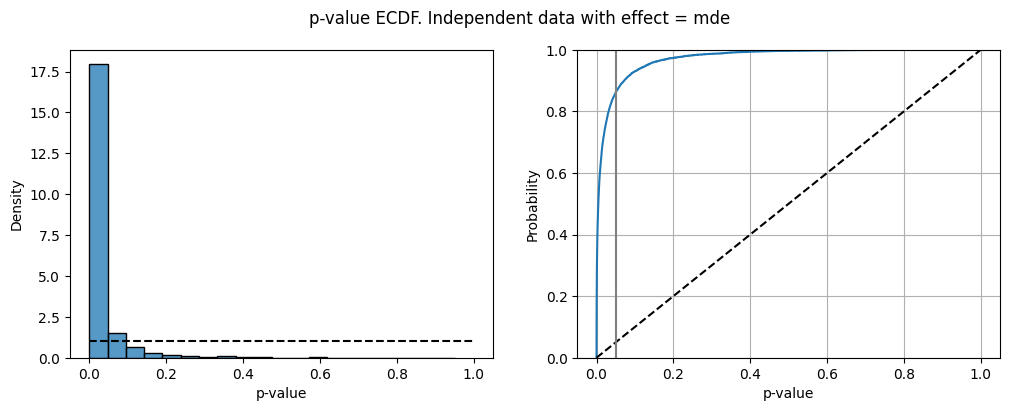

In [107]:
mean = sales_by_user['price'].mean()
std = sales_by_user['price'].std()
sample_size = 1000
alpha = 0.05
#beta = 0.2
effect = 0.1


p_values = []
grouped_sales = sales_filt.groupby('user_id', as_index=False).agg({'price': 'sum'}).reset_index()
users = sales_filt['user_id'].unique().tolist()
for _ in range(10000):
    np.random.shuffle(users)
    group_a = random.sample(users, sample_size)
    group_b = random.sample(users, sample_size)
    sales_a = grouped_sales[grouped_sales['user_id'].isin(group_a)]['price']
    sales_b = grouped_sales[grouped_sales['user_id'].isin(group_b)]['price']
    indexes = np.random.choice(np.arange(sample_size), int(sample_size * 0.025), False)
    add_value = effect * mean * sample_size / len(indexes)
    sales_b1 = sales_b[:len(indexes)] + add_value
    sales_b2 = sales_b[len(indexes):]
    sales_b = sales_b1.append(sales_b2)
    _, p_val = ttest_ind(sales_a, sales_b)
    p_values.append(p_val)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Independent data with effect = mde')

#### Task 2.

tbc..